In [1]:
import sys, os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

batch_size=128
epochs=3
no_cuda=False 
log_interval=100

cuda = not no_cuda and torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 2)
        self.fc22 = nn.Linear(512, 2)
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
#     BCE_loss_func = nn.BCELoss(reduction='sum') 
    BCE = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: 37.8169
====> Test set loss: 38.0854
====> Epoch: 2 Average loss: 37.6953
====> Test set loss: 38.1464
====> Epoch: 3 Average loss: 37.6478
====> Test set loss: 38.1667
====> Epoch: 4 Average loss: 37.5669
====> Test set loss: 37.9998
====> Epoch: 5 Average loss: 37.5001
====> Test set loss: 38.0760
====> Epoch: 6 Average loss: 37.4187
====> Test set loss: 37.8204
====> Epoch: 7 Average loss: 37.3334
====> Test set loss: 37.8387
====> Epoch: 8 Average loss: 37.3004
====> Test set loss: 37.9113
====> Epoch: 9 Average loss: 37.2327
====> Test set loss: 37.9319
====> Epoch: 10 Average loss: 37.2015
====> Test set loss: 37.8065
====> Epoch: 11 Average loss: 37.1323
====> Test set loss: 37.8197
====> Epoch: 12 Average loss: 37.0886
====> Test set loss: 37.7797
====> Epoch: 13 Average loss: 37.0306
====> Test set loss: 37.7722
====> Epoch: 14 Average loss: 37.0045
====> Test set loss: 37.7050
====> Epoch: 15 Average loss: 36.9250
====> Test set loss: 37.6556
====

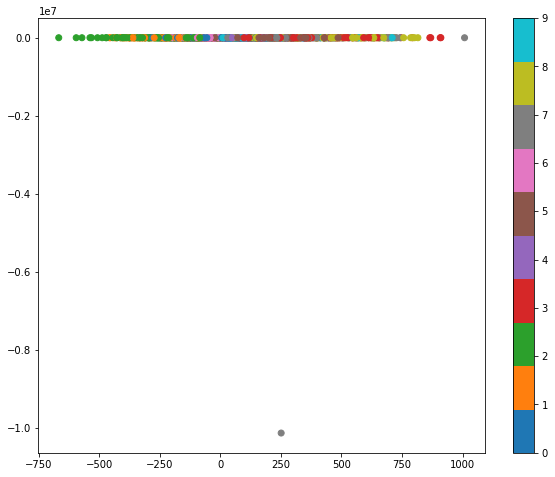

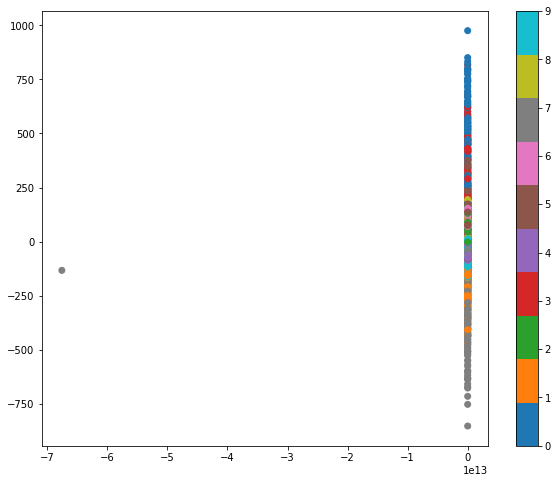

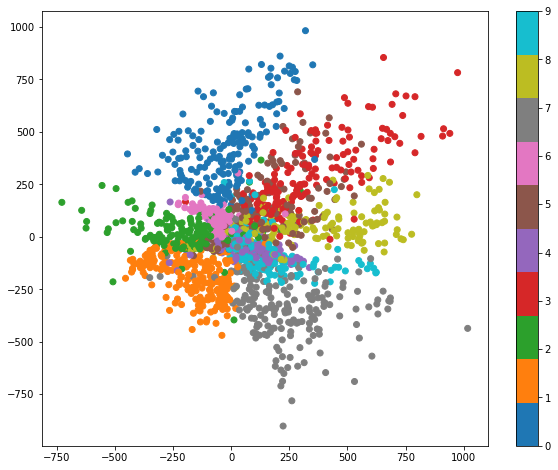

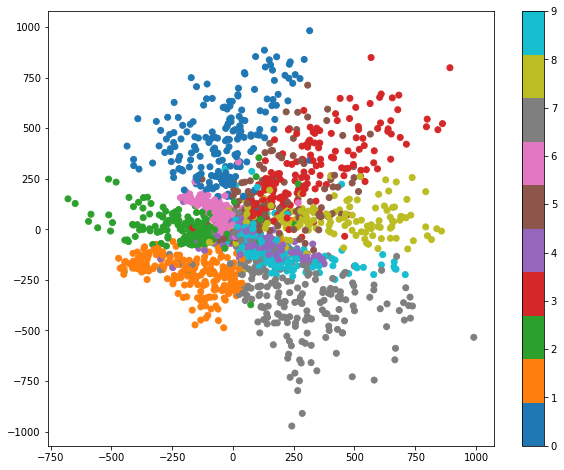

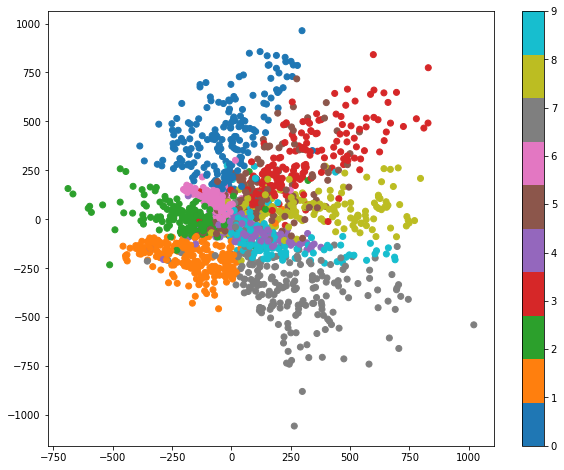

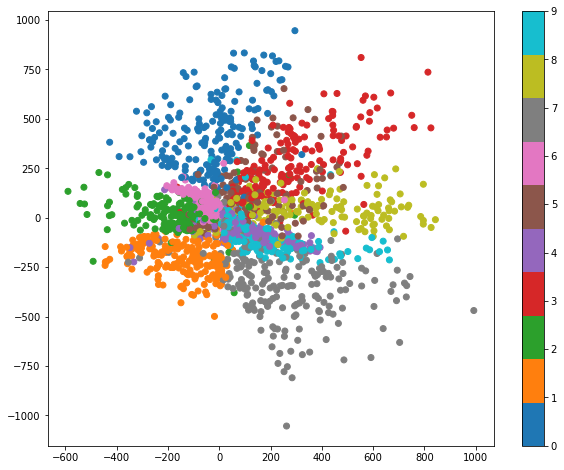

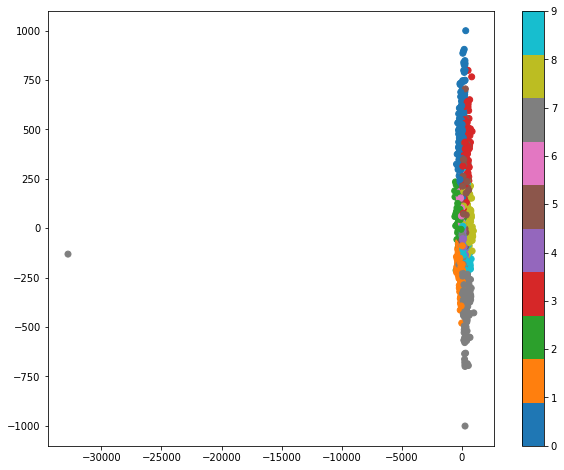

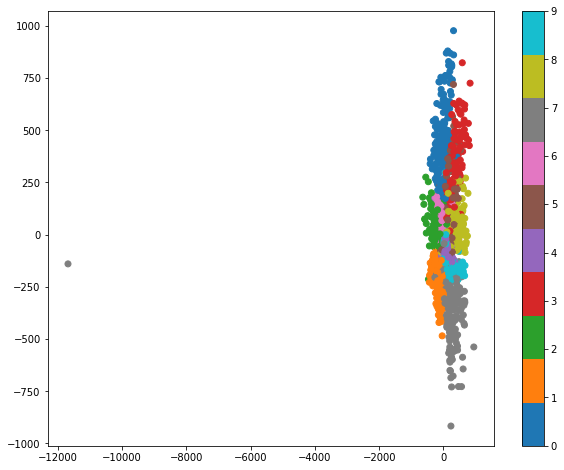

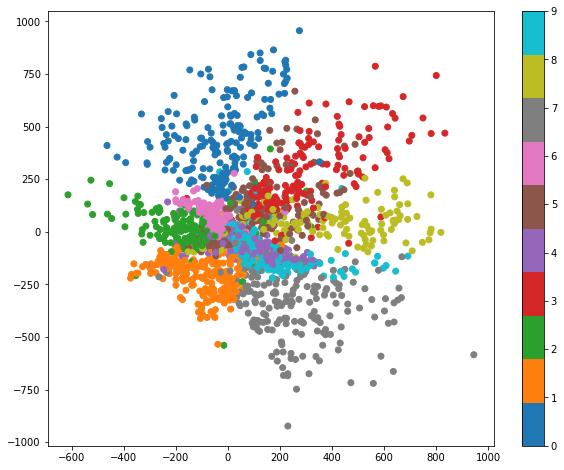

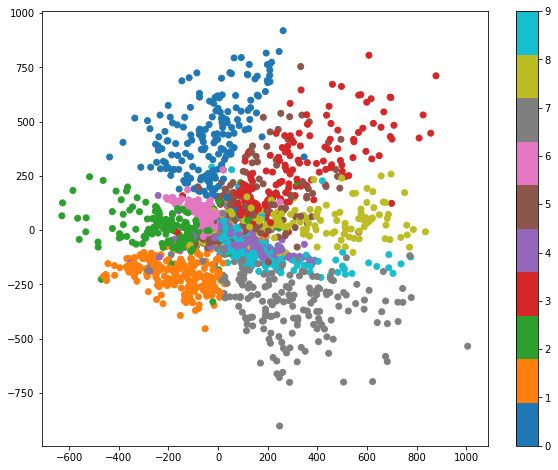

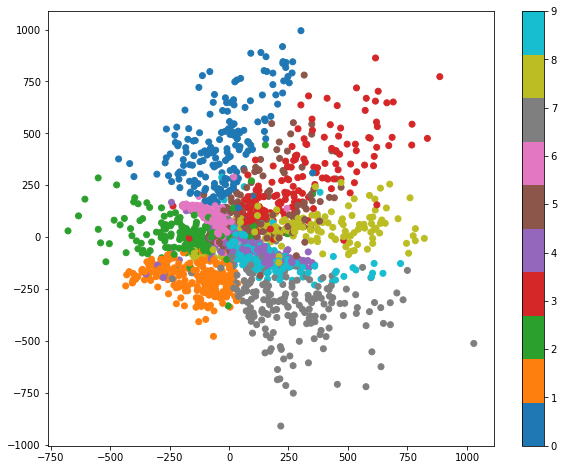

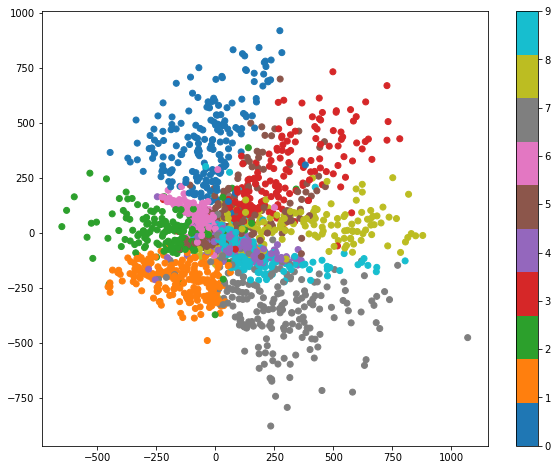

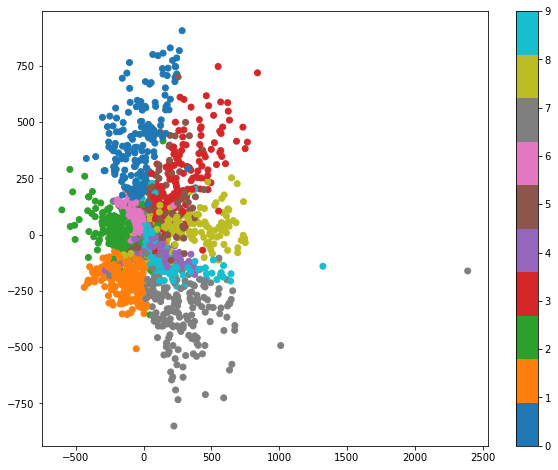

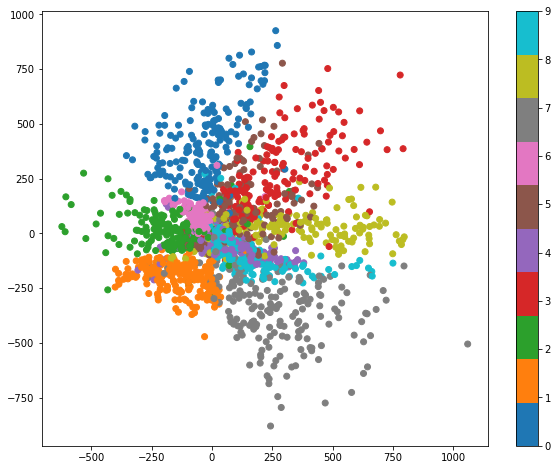

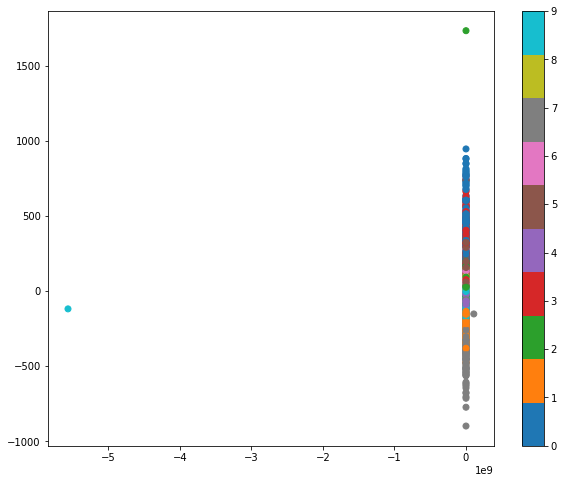

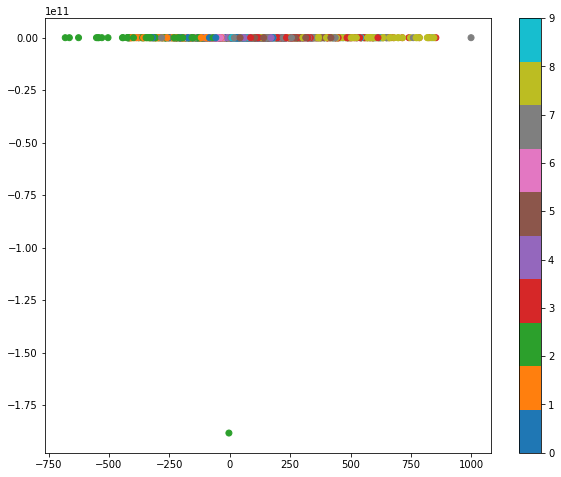

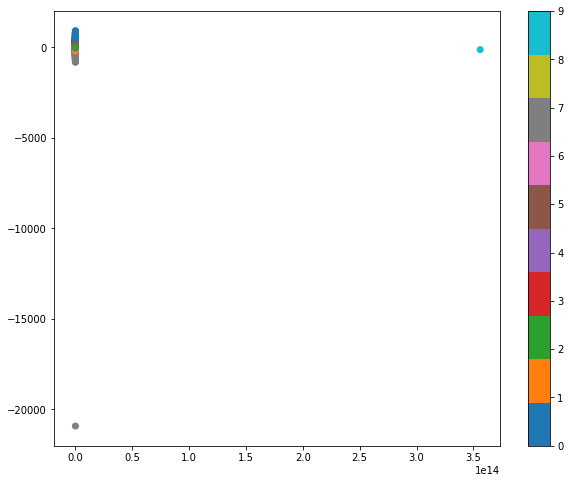

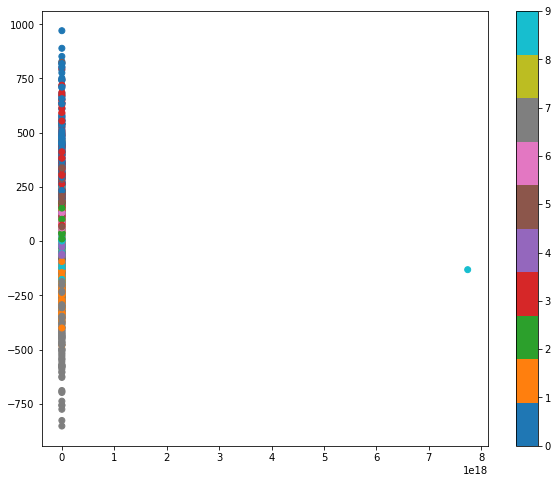

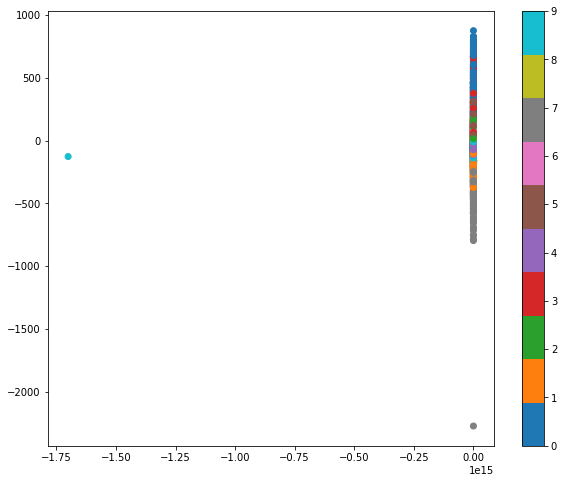

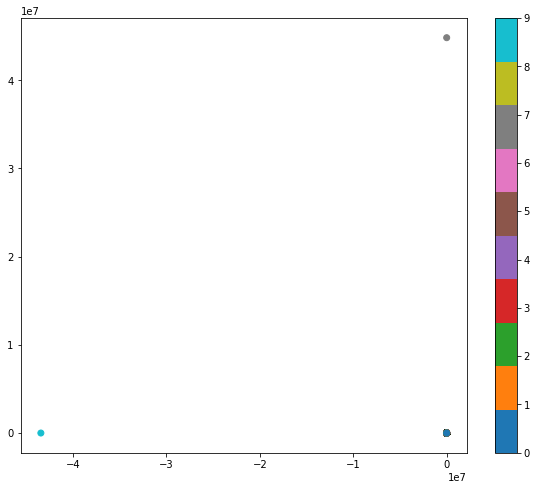

In [4]:
import matplotlib.pyplot as plt
epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad(): 
        train_all = train_loader.dataset.train_data.reshape(-1, 784).float().to(device)
        encoded_mu, encoded_logvar = model.encode(train_all) 
        encoded_latent = model.reparameterize(encoded_mu, encoded_logvar) 
        decoded = model(train_all) 
#         sample = torch.randn(64, 2).to(device)
#         sample = model.decode(sample).cpu()
#         save_image(sample.view(64, 1, 28, 28),
#                    'results/sample_' + str(epoch) + '.png') 
    plt.figure(figsize=(10,8))
    plt.scatter(encoded_latent.cpu()[:2000,0], encoded_latent.cpu()[:2000,1], c=train_loader.dataset.train_labels.cpu()[:2000], cmap='tab10')
    plt.colorbar()   
    plt.savefig('./results/vae_result_epoch%d.pdf' % epoch) 

In [4]:
with torch.no_grad(): 
    train_all = train_loader.dataset.train_data.reshape(-1, 784).float().to(device)
    print(train_all.shape)
    encoded_mu, encoded_logvar = model.encode(train_all) 
    encoded_latent = model.reparameterize(encoded_mu, encoded_logvar) 
    decoded = model(train_all)

torch.Size([60000, 784])


In [5]:
import matplotlib.pyplot as plt

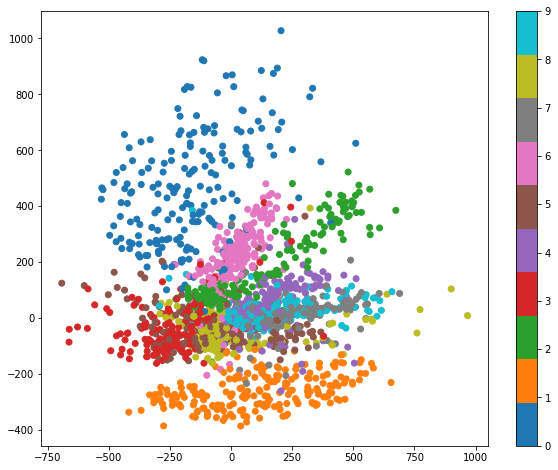

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(encoded_latent.cpu()[:2000,0], encoded_latent.cpu()[:2000,1], c=train_loader.dataset.train_labels.cpu()[:2000], cmap='tab10')
plt.colorbar()

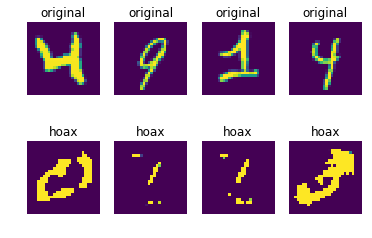

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
fig, ax = plt.subplots(nrows=2, ncols=4) 

for i in range(10,14): 
    ax[0,i-10].imshow(np.squeeze(train_all.cpu())[2*i].reshape(28,28)) 
    ax[0,i-10].set_title('original')
    ax[1,i-10].imshow(np.squeeze(decoded[0].cpu().numpy())[2*i+1].reshape(28,28)) 
    ax[1,i-10].set_title('hoax')
    ax[0,i-10].axis('off') 
    ax[1,i-10].axis('off')
plt.show()

In [19]:
>>> loss = nn.CrossEntropyLoss()
>>> input = torch.randn(3, 5, requires_grad=True)
>>> target = torch.empty(3, dtype=torch.long).random_(5)
>>> output = loss(input, target)
>>> output.backward()

In [25]:
target.random_(5)

tensor([0, 3, 1])

In [18]:
[2:5]

SyntaxError: invalid syntax (<ipython-input-18-dc587c043a4c>, line 1)